In [6]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch import nn
import torch_geometric.nn as geom_nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [7]:
def particle_shift(particles,shift=10):

    ### Y shift ###
    y_pos = particles.copy()
    y_pos["y"] = particles["y"]+shift

    y_neg = particles.copy()
    y_neg["y"] = particles["y"]-shift

    ### Z shift ###
    z_pos = particles.copy()
    z_pos["z"] = particles["z"]+shift

    z_neg = particles.copy()
    z_neg["z"] = particles["z"]-shift

    ### Diagonal shifts ###
    ### y_pos_z_pos ###
    y_pos_z_pos = particles.copy()
    y_pos_z_pos["y"] = particles["y"]+shift
    y_pos_z_pos["z"] = particles["z"]+shift

    ### y_pos_z_neg ###
    y_pos_z_neg = particles.copy()
    y_pos_z_neg["y"] = particles["y"]+shift
    y_pos_z_neg["z"] = particles["z"]-shift

    ### y_neg_z_pos ###
    y_neg_z_pos = particles.copy()
    y_neg_z_pos["y"] = particles["y"]-shift
    y_neg_z_pos["z"] = particles["z"]+shift

    ### y_neg_z_neg ###
    y_neg_z_neg = particles.copy()
    y_neg_z_neg["y"] = particles["y"]-shift
    y_neg_z_neg["z"] = particles["z"]-shift

    return pd.concat([particles,y_pos,y_neg,z_pos,z_neg,y_pos_z_pos,y_pos_z_neg,y_neg_z_pos,y_neg_z_neg])

### array Differences function ###

def array_difference(array1,array2):
    ### First one must be the bigger array ###
    set1 = set(map(tuple, array1))
    set2 = set(map(tuple, array2))
    
    # Find the set difference
    set_difference = set1 - set2

    # Convert the set difference back to a NumPy array
    return np.array(list(set_difference))

def get_edge_connections(poi,deg_1_neighbors,deg_2_neighbors):

    ### Poi : np.array() with size (3,) ###
    ### deg_1_neighbors,deg_2_neighbors : numpy arrays with size (n,3) and (m,3) ###
    ### As of now works for 2 degrees of connections ##S
    deg_2_neighbors_np = np.stack(deg_2_neighbors).reshape(np.stack(deg_2_neighbors).shape[0]*np.stack(deg_2_neighbors).shape[1],3)
    ### poi ###
    temp_1 = np.concatenate((poi[None,:], [[0]]), axis=1)
    
    ### 1st deg neighbors ###
    temp_2 = np.concatenate((deg_1_neighbors,np.ones_like(np.arange(deg_1_neighbors.shape[0]))[:,None]),axis=1)
    
    ### 2nd deg neighbors ###
    _,idx = np.unique(deg_2_neighbors_np,axis=0,return_index=True)
    idx = np.sort(idx)
    temp_3 = np.concatenate((deg_2_neighbors_np[idx],np.ones_like(np.arange(deg_2_neighbors_np[idx].shape[0]))[:,None]*2),axis=1)

    ### Define unique array ###
    unique_array = np.concatenate((temp_1,temp_2,temp_3))
    unique_array = np.concatenate((np.arange(unique_array.shape[0])[:,None],unique_array),axis=1)
  
    ### generating the graph connections ###
    graph_connections = list()
    
    ### poi and 1st order neighbors ###
    graph_connections.append( np.concatenate( (np.zeros_like(deg_1_neighbors[:,0][:,None])
                                              ,(np.arange(deg_1_neighbors.shape[0])+1)[:,None]),axis=1 ) )
    graph_connections[0] = graph_connections[0].astype(int)
    
    ### 1 and 2 order neighbors ###
    for i in range(len(deg_2_neighbors)):
        idx = np.where( (deg_2_neighbors[i]==unique_array[:,1:-1][:,None]).all(-1) )[0]
        graph_connections.append(np.concatenate((np.ones_like(idx[:,None])*(i+1),idx[:,None]),axis=1))
        
    return unique_array,np.vstack(graph_connections)

def add_const_parameter(data,const_param):

    temp = [ np.concatenate( (data[i][0],np.ones_like(data[i][0][:,0][:,None])*const_param ),axis=1) for i in range(len(data))] 
    res = [ [temp[i],data[i][1]] for i in range(len(data)) ]
    return res

def min_max_scaler(data,train_indices):

    ### Extracting Train Dataset ###
    train_dat = [ data[train_indices[i]] for i in range(len(train_indices)) ]

    ### Extracting Test Dataset ###
    test_indices = np.setdiff1d( np.arange(len(data)) , train_indices  )
    test_dat = [ data[test_indices[i]] for i in range(len(test_indices)) ]

    ### Scaling inputs ###
    ### Getting min and max values ###
    max_vals = np.max(np.stack([train_dat[i].x[:,j].max() for i in 
                                range(len(train_dat)) for j in range(train_dat[i].x.shape[1]) ]).reshape(len(train_dat),train_dat[0].x.shape[1]),axis=0)
    
    min_vals = np.min(np.stack([train_dat[i].x[:,j].min() for i in 
                                range(len(train_dat)) for j in range(train_dat[i].x.shape[1]) ]).reshape(len(train_dat),train_dat[0].x.shape[1]),axis=0)
    
    ### Performing the scaling ###
    train_dat_input = [ (train_dat[i].x - min_vals)/(max_vals - min_vals) for i in range(len(train_dat))] 
    test_dat_input = [ (test_dat[i].x - min_vals)/(max_vals - min_vals) for i in range(len(test_dat))]

    ### Scaling outputs ###
    ### Getting min and max values ###
    max_vals = np.max( np.stack( [train_dat[i].y.max() for i in range(len(train_dat))] ),axis=0)
    min_vals = np.min( np.stack( [train_dat[i].y.min() for i in range(len(train_dat))] ),axis=0)

    ### Performing the scaling ###
    train_dat_output = [ (train_dat[i].y - min_vals)/(max_vals - min_vals) for i in range(len(train_dat))] 
    test_dat_output = [ (test_dat[i].y - min_vals)/(max_vals - min_vals) for i in range(len(test_dat))]

    ### Combine x and y edge indices from the train and test dataset to form a pygnn Data variable ###
    train_combined = list()
    test_combined = list()
    
    for i in range(len(train_dat_input)):

        x = train_dat_input[i].clone()
        edge_index = (train_dat[i].edge_index).clone()
        y = (train_dat_output[i]).clone()
        train_combined.append(Data(x=x , edge_index=edge_index , y=y))

    for i in range(len(test_dat_input)):

        x = test_dat_input[i].clone()
        edge_index = (test_dat[i].edge_index).clone()
        y = (test_dat_output[i]).clone()
        test_combined.append(Data(x=x , edge_index=edge_index , y=y))

    return train_combined,test_combined

def mirror_edge_index(edge_index):

    first_row = edge_index[0:1, :]
    second_row = edge_index[1:, :]
    output_tensor = np.concatenate((second_row, first_row), axis=0)
    
    return np.concatenate((edge_index,output_tensor),axis=1)


def weighted_averaging(data):
    
    idx = np.where(data[0][:,4]==0)[0]
    deg_1 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==1)[0]
    deg_2 = data[0][idx,1:4].sum()

    idx = np.where(data[0][:,4]==2)[0]
    deg_3 = data[0][idx,1:4].sum()

    return deg_1 + 0.5*deg_2 + 0.25*deg_3 

### Validation ###
# print(all_dat[0].edge_index[:,0:5])
# test = mirror_edge_index(all_dat[0].edge_index[:,0:5].detach().cpu().numpy())
# print(test)

In [8]:
### Reading Raw Data ###
df = pd.read_csv('AR2p5_all_particle_drag.dat.csv', header=0)
all_tags = np.load("ze_tags_2p5.npy")

### Read all center data ###
center_10 = pd.DataFrame(np.loadtxt("center_phi_10.dat"))
center_10 = center_10.rename(columns={ center_10.columns[3]: "x" , center_10.columns[4]: "y" , center_10.columns[5]: "z"  })
center_10 = center_10[(center_10['x']>7.5) & (center_10['x']<17.5)]

center_20 = pd.DataFrame(np.loadtxt("center_phi_20.dat"))
center_20 = center_20.rename(columns={ center_20.columns[3]: "x" , center_20.columns[4]: "y" , center_20.columns[5]: "z"  })
center_20 = center_20[(center_20['x']>7.5) & (center_20['x']<17.5)]

center_30 = pd.DataFrame(np.loadtxt("center_phi_30.dat"))
center_30 = center_30.rename(columns={ center_30.columns[3]: "x" , center_30.columns[4]: "y" , center_30.columns[5]: "z"  })
center_30 = center_30[(center_30['x']>7.5) & (center_30['x']<17.5)]

### Defining all particles ###
center_shifted_10 = particle_shift(center_10,shift=10)[['x','y','z']]
center_shifted_20 = particle_shift(center_20,shift=10)[['x','y','z']]
center_shifted_30 = particle_shift(center_30,shift=10)[['x','y','z']]
all_particles = np.concatenate((center_shifted_10,center_shifted_20,center_shifted_30))

In [9]:
### Defining Real particles ###
variable_list = ['Center_x','Center_y','Center_z','phi','Re','Inclination_angle','Drag_local']
real_particles = df[(df["Center_x"]>7.5)&(df["Center_x"]<17.5)][variable_list]

In [10]:
### Generate Dataset ###
### getting 15 nearest neighbors indices ###
tree = cKDTree(all_particles)
idx = np.stack([tree.query(real_particles.iloc[i][["Center_x","Center_y","Center_z"]].values,16)[1] for i in range(len(real_particles))])

### Bringing it all together ###
all_data = list()
for i in range(len(real_particles)):
    print("On particle : ",str(i+1))
    temp_poi = real_particles.iloc[i][["Center_x","Center_y","Center_z","Re","phi","Inclination_angle","Drag_local"]].values
    temp_neighbors = np.array(df.iloc[idx[0][1:]][["Center_x","Center_y","Center_z"]]).flatten()
    all_data.append(np.concatenate((temp_poi[0:3], temp_neighbors, temp_poi[3:])))
    clear_output(wait=True)

On particle :  4736


In [11]:
all_data_pd = pd.DataFrame(all_data,columns=["POI_x","POI_y","POI_y",
                                             "neigh_1_x","neigh_1_y","neigh_1_z",
                                             "neigh_2_x","neigh_2_y","neigh_2_z",
                                             "neigh_3_x","neigh_3_y","neigh_3_z",
                                             "neigh_4_x","neigh_4_y","neigh_4_z",
                                             "neigh_5_x","neigh_5_y","neigh_5_z",
                                             "neigh_6_x","neigh_6_y","neigh_6_z",
                                             "neigh_7_x","neigh_7_y","neigh_7_z",
                                             "neigh_8_x","neigh_8_y","neigh_8_z",
                                             "neigh_9_x","neigh_9_y","neigh_9_z",
                                             "neigh_10_x","neigh_10_y","neigh_10_z",
                                             "neigh_11_x","neigh_11_y","neigh_11_z",
                                             "neigh_12_x","neigh_12_y","neigh_12_z",
                                             "neigh_13_x","neigh_13_y","neigh_13_z",
                                             "neigh_14_x","neigh_14_y","neigh_14_z",
                                             "neigh_15_x","neigh_15_y","neigh_16_z",
                                              "Re","Phi","Inclination_angle","Drag_local"])
all_data_pd

,POI_x,POI_y,POI_y,neigh_1_x,neigh_1_y,neigh_1_z,neigh_2_x,neigh_2_y,neigh_2_z,neigh_3_x,...,neigh_14_x,neigh_14_y,neigh_14_z,neigh_15_x,neigh_15_y,neigh_16_z,Re,Phi,Inclination_angle,Drag_local
0,10.876728,8.580914,1.499941,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,32.081738,3.903370
1,12.929652,8.518986,8.546638,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,77.315739,5.023779
2,17.018229,8.503029,1.464684,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,52.642073,4.573232
3,16.603652,1.499732,9.825560,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,60.625083,6.699245
4,11.737969,1.485545,9.792119,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,51.275008,7.034383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4731,9.057059,2.669999,8.314206,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,200.0,30.0,77.808798,53.346913
4732,15.632600,6.765237,6.832840,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,200.0,30.0,54.035214,44.935589
4733,12.114195,7.278870,6.658870,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,200.0,30.0,38.850731,44.519320
4734,13.199404,1.211223,9.910920,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,200.0,30.0,47.605903,30.597811


In [12]:
drags = np.concatenate( (all_data_pd["Drag_local"].values[0:207*4+402*4],
                 all_data_pd[(all_data_pd["Re"]==10)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
                 all_data_pd[(all_data_pd["Re"]==50)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
                 all_data_pd[(all_data_pd["Re"]==100)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values,
                 all_data_pd[(all_data_pd["Re"]==200)&(all_data_pd["Phi"]==30)]["Drag_local"][0:549].values))
drags

array([ 3.90337 ,  5.023779,  4.573232, ..., 65.980866, 53.919616,
       35.73782 ])

In [13]:
# np.save("ze_drags_2p5",all_data_pd["Drag_local"].values)

In [14]:
### Splitting data as train and test ###
check_points = np.array([0,center_10.shape[0],center_10.shape[0],center_10.shape[0],center_10.shape[0],
          center_20.shape[0],center_20.shape[0],center_20.shape[0],center_20.shape[0],
         center_30.shape[0],center_30.shape[0],center_30.shape[0],center_30.shape[0]]).cumsum() 

test_indices = np.stack([np.arange(40) + check_points[i] for i in range(len(check_points)-1)]).flatten()
train_indices = np.setdiff1d( np.arange(len(all_data)) , test_indices )

train_data_pd = all_data_pd.iloc[train_indices]
test_data_pd = all_data_pd.iloc[test_indices]

In [15]:
### Scaling the train and test dataset ###
scaler = MinMaxScaler()
scaler.fit(train_data_pd)
train_data_pd_scaled = scaler.transform(train_data_pd)
test_data_pd_scaled = scaler.transform(test_data_pd)

### splitting to input and outputs ##3
train_inputs,train_outputs = train_data_pd_scaled[:,0:51],train_data_pd_scaled[:,51:]
test_inputs,test_outputs = test_data_pd_scaled[:,0:51],test_data_pd_scaled[:,51:]

In [16]:
train_data_pd

,POI_x,POI_y,POI_y,neigh_1_x,neigh_1_y,neigh_1_z,neigh_2_x,neigh_2_y,neigh_2_z,neigh_3_x,...,neigh_14_x,neigh_14_y,neigh_14_z,neigh_15_x,neigh_15_y,neigh_16_z,Re,Phi,Inclination_angle,Drag_local
40,13.137204,7.388673,9.134358,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,38.412987,4.675028
41,12.961300,4.253836,0.058247,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,27.834629,4.006110
42,9.388220,2.936770,9.377717,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,56.318800,6.265856
43,15.314176,2.252765,8.685401,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,74.014432,3.291547
44,12.637778,2.087273,0.319745,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,10.0,10.0,66.724320,5.811171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4731,9.057059,2.669999,8.314206,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,200.0,30.0,77.808798,53.346913
4732,15.632600,6.765237,6.832840,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,200.0,30.0,54.035214,44.935589
4733,12.114195,7.278870,6.658870,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,200.0,30.0,38.850731,44.519320
4734,13.199404,1.211223,9.910920,16.054363,6.133757,4.291713,10.023264,0.977261,5.788375,5.964162,...,14.679917,8.510891,8.740622,15.262335,8.526234,2.21682,200.0,30.0,47.605903,30.597811


In [119]:
### Define MLP model ###
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(51, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16, 1) 
        )

    def forward(self, x):
        return self.layers(x)
model =  MLP()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

57089


In [120]:
### Define Train and Test and loaders ###
train_loader = DataLoader(list(zip(train_inputs,train_outputs)), batch_size=16, shuffle=True)
test_loader = DataLoader(list(zip(test_inputs,test_outputs)), batch_size=16, shuffle=True)

In [121]:
model =  MLP().cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.015)

epoch_loss_train = list()
epoch_loss_val = list()

for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    loss_train = list()
    loss_val = list()
    
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.float().cuda(), targets.float().cuda()
        # targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = model(inputs)

        # print("GT and Pred :",str(targets),str(outputs))
        
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        loss_train.append(loss.item())
        
    for i, data in enumerate(test_loader, 0):

        inputs, targets = data
        inputs, targets = inputs.float().cuda(), targets.float().cuda()
        loss = loss_function(outputs, targets)
        loss_val.append(loss.item())
        
    print(f'Epoch {epoch+1} finished with training loss = '+str(np.array(loss_train).mean()))
    print(f'testing loss = '+str(np.array(loss_val).mean()) + '\n' )

    epoch_loss_train.append(np.array(loss_train).mean())
    epoch_loss_val.append(np.array(loss_val).mean())    

print("Training has completed")

Starting Epoch 1
Epoch 1 finished with training loss = 0.01013360124718594
testing loss = 0.04025534447282553

Starting Epoch 2
Epoch 2 finished with training loss = 0.0037621404812408655
testing loss = 0.04207593643416961

Starting Epoch 3
Epoch 3 finished with training loss = 0.003564134445846697
testing loss = 0.060036459689339

Starting Epoch 4
Epoch 4 finished with training loss = 0.0034602528206673206
testing loss = 0.04164729869614045

Starting Epoch 5
Epoch 5 finished with training loss = 0.003404936113804439
testing loss = 0.042935643903911115

Starting Epoch 6
Epoch 6 finished with training loss = 0.003330457835244645
testing loss = 0.04615772496908903

Starting Epoch 7
Epoch 7 finished with training loss = 0.003297666634154625
testing loss = 0.05139484206835429

Starting Epoch 8
Epoch 8 finished with training loss = 0.0032708530736162813
testing loss = 0.049660153997441135

Starting Epoch 9
Epoch 9 finished with training loss = 0.003229579880625304
testing loss = 0.035272973

0.002426622800123738 0.053881306946277616


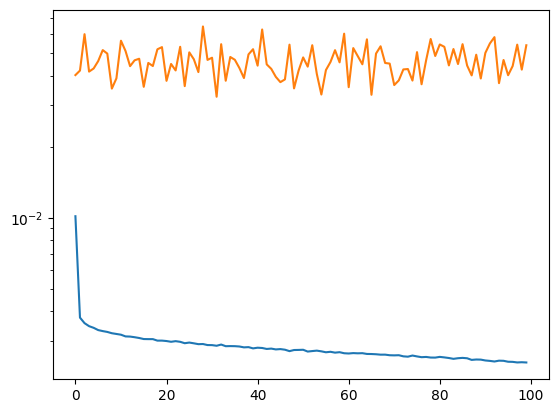

In [122]:
import matplotlib.pyplot as plt
plt.semilogy(epoch_loss_train)
plt.semilogy(epoch_loss_val)
print(epoch_loss_train[-1],epoch_loss_val[-1])

In [123]:
# torch.save(model.state_dict(),"model_mlp")
# model.load_state_dict(torch.load("model_general"))
# model = model.to(device)

In [124]:
### Deploying trained model on test dataset ###
train_predictions = list()
for i in range(len(train_inputs)):
    temp_input = torch.tensor(train_inputs[i,:][None,:]).cuda().float()
    train_predictions.append(model(temp_input))

train_predictions = torch.stack(train_predictions).detach().cpu().numpy()
train_results = np.concatenate((train_inputs,train_predictions[:,0]),axis=1)
train_results = scaler.inverse_transform(train_results)
train_results_pd = pd.DataFrame(np.concatenate( (train_results[:,[-4,-3,-1]],train_data_pd["Drag_local"].values[:,None]),axis=1)
                                ,columns=["Re","Phi","Pred","GT"])

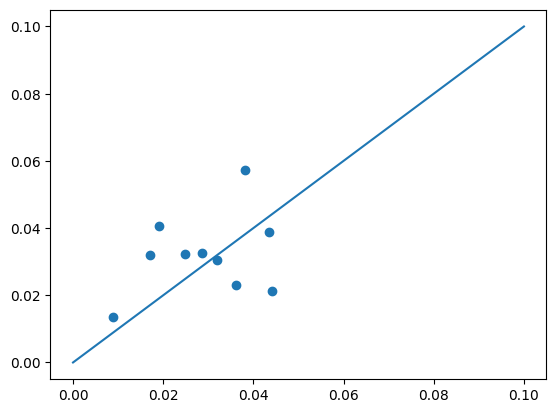

In [125]:
df_result = pd.DataFrame(np.concatenate((train_outputs,train_predictions[:,0]),axis=1),columns=["GT","Pred"])
plt.scatter(df_result["GT"].iloc[0:10],df_result["Pred"].iloc[0:10])
plt.plot(np.linspace(0,0.1,10),np.linspace(0,0.1,10))

In [126]:
### Deploying trained model on test dataset ###
test_predictions = list()
for i in range(len(test_inputs)):
    temp_input = torch.tensor(test_inputs[i,:][None,:]).cuda().float()
    test_predictions.append(model(temp_input))

test_predictions = torch.stack(test_predictions).detach().cpu().numpy()

In [127]:
test_results = np.concatenate((test_inputs,test_predictions[:,0]),axis=1)
test_results = scaler.inverse_transform(test_results)
test_results_pd = pd.DataFrame(np.concatenate( (test_results[:,[-4,-3,-1]],test_data_pd["Drag_local"].values[:,None]),axis=1)
                                ,columns=["Re","Phi","Pred","GT"])

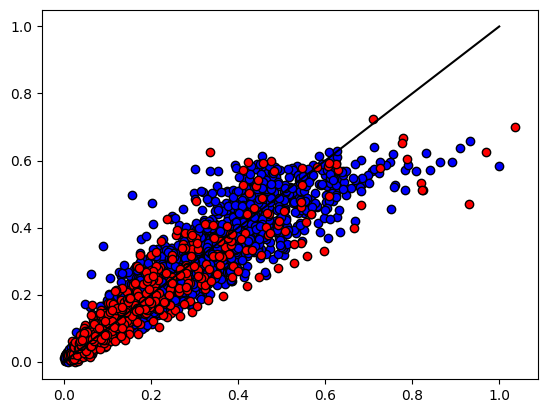

In [133]:
plt.scatter(train_outputs,train_predictions,c="blue",edgecolor='black')
plt.scatter(test_outputs,test_predictions,c="red",edgecolor='black')
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),c='black')

In [143]:
np.sum((test_outputs - test_predictions[:,0])**2)/len(test_outputs)

0.0054283784799628145

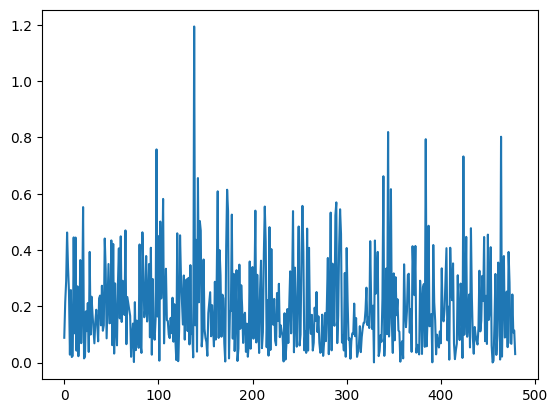

In [22]:
test_results_pd["Rel_err"] = np.abs(test_results_pd["GT"]-test_results_pd["Pred"])/(test_results_pd["GT"])
test_results_pd["Rel_err"]
plt.plot(test_results_pd["Rel_err"])
# count, bins_count = np.histogram(data, bins=10) 
  
# # finding the PDF of the histogram using count values 
# pdf = count / sum(count) 
  
# # using numpy np.cumsum to calculate the CDF 
# # We can also find using the PDF values by looping and adding 
# cdf = np.cumsum(pdf) 
  
# # plotting PDF and CDF 
# plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
# plt.plot(bins_count[1:], cdf, label="CDF") 
# plt.legend() 

-0.14920026882031556


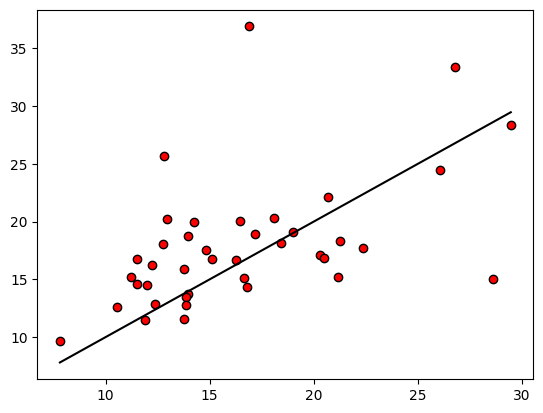

In [43]:
Re=10
Phi=30

test_subgroup = test_results_pd[(test_results_pd["Re"]==Re)&(test_results_pd["Phi"]==Phi)]
plt.scatter(test_subgroup["GT"],test_subgroup["Pred"],c="red",edgecolor='black')
plt.plot(np.linspace(test_subgroup["GT"].min(),test_subgroup["GT"].max(),10),
         np.linspace(test_subgroup["GT"].min(),test_subgroup["GT"].max(),10),c='black')
print(r2_score(test_subgroup["GT"].values,test_subgroup["Pred"].values))

In [31]:
gt = test_subgroup["GT"].values
mean = np.ones(len(test_subgroup))*test_subgroup["GT"].values.mean()
pred = test_subgroup["Pred"].values

rel_err_mean = (np.abs(gt-mean)/(gt))*100
rel_err_pred = (np.abs(gt-pred)/(gt))*100
rel_err_mean.mean()

25.421176707073744

In [32]:
rel_err_pred.mean()

20.601934185496177